In [70]:
import tensorflow as tf
import kagglehub
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, Concatenate, Dropout, GlobalAveragePooling2D, MaxPooling2D, Dense
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model
import random
import shutil
import cv2
from PIL import Image
from tensorflow.keras.utils import plot_model

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# data processing

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [00:23<00:00, 121MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [48]:
ROOT_DIR = path + '/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)'
TRAIN_DIR = ROOT_DIR + '/train'
VALID_DIR = ROOT_DIR + '/valid'
TEST_DIR = path + '/test'

In [9]:
import kagglehub

# Download latest version
rice_path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")

print("Path to dataset files:", rice_path)

100%|██████████| 36.7M/36.7M [00:00<00:00, 95.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/rice-leaf-diseases/versions/1


In [30]:
import kagglehub

# Download latest version
wheet_path = kagglehub.dataset_download("olyadgetch/wheat-leaf-dataset")

print("Path to dataset files:", wheet_path)

100%|██████████| 1.41G/1.41G [00:18<00:00, 83.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/olyadgetch/wheat-leaf-dataset/versions/1


In [49]:
def data_adder(data, train_dir, valid_dir, first_class_name):
    train_rato = 0.8
    valid_rato = 0.2
    for label in os.listdir(data):

      os.makedirs(os.path.join(train_dir, label))
      os.makedirs(os.path.join(valid_dir, label))

      class_path = os.path.join(data, label)

      image_files = os.listdir(class_path)
      train_num = int(len(image_files) * train_rato)
      train_images = image_files[:train_num]
      valid_images = image_files[train_num:]

      for file in train_images:
        img = cv2.imread(os.path.join(data, label, file))
        height, width = img.shape[0], img.shape[1]

        if height >= 256 and width >=256:
          croped = img[int((height - 256) / 2) : int((height - 256) / 2) + 256, int((width - 256) / 2) : int((width - 256) / 2) + 256]
          img = Image.fromarray(croped)
          img.save(os.path.join(train_dir, label, file))


        else:
          continue

      for file in valid_images:
        img = cv2.imread(os.path.join(data, label, file))
        height, width = img.shape[0], img.shape[1]

        if height >= 256 and width >= 256:
          croped = img[int((height - 256) / 2) : int((height - 256) / 2) + 256, int((width - 256) / 2) : int((width - 256) / 2) + 256]
          img = Image.fromarray(croped)
          img.save(os.path.join(valid_dir, label, file))
        else:
          continue


## add rice dataset to main dataest

In [50]:
data_adder('/root/.cache/kagglehub/datasets/vbookshelf/rice-leaf-diseases/versions/1/rice_leaf_diseases', TRAIN_DIR, VALID_DIR, 'Bacterial leaf blight')

In [53]:
os.rmdir('/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/.ipynb_checkpoints')

## add wheet dataset to main dataset

In [54]:
data_adder('/root/.cache/kagglehub/datasets/olyadgetch/wheat-leaf-dataset/versions/1/wheat_leaf', TRAIN_DIR, VALID_DIR, 'wheet_Healthy')

In [55]:
for i in os.listdir(TRAIN_DIR):
  print(i, '           ', len(os.listdir(TRAIN_DIR + '/' + i)))

Potato___healthy             1824
Apple___Apple_scab             2016
Tomato___Early_blight             1920
Grape___Black_rot             1888
Apple___Black_rot             1987
Apple___healthy             2008
Tomato___Target_Spot             1827
Soybean___healthy             2022
.ipynb_checkpoints             0
Apple___Cedar_apple_rust             1760
Potato___Early_blight             1939
wheet_stripe_rust             166
Tomato___Leaf_Mold             1882
Corn_(maize)___healthy             1859
Tomato___Septoria_leaf_spot             1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot             1642
Corn_(maize)___Northern_Leaf_Blight             1908
Strawberry___Leaf_scorch             1774
Tomato___Tomato_Yellow_Leaf_Curl_Virus             1961
Strawberry___healthy             1824
Grape___Esca_(Black_Measles)             1920
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)             1722
Pepper,_bell___Bacterial_spot             1913
Tomato___Tomato_mosaic_virus        

In [56]:
len(os.listdir(TRAIN_DIR))

45

In [57]:
image_data_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
)

train_data = image_data_gen.flow_from_directory(
    directory = TRAIN_DIR,
    batch_size = 64,
    shuffle = True,
    target_size=(256, 256)
)

valid_data = image_data_gen.flow_from_directory(
    directory = VALID_DIR,
    batch_size = 64,
    shuffle = True,
    target_size=(256, 256)
)

Found 70695 images belonging to 45 classes.
Found 17674 images belonging to 45 classes.


# model

In [58]:
inputs = Input(shape = (256, 256, 3), name='input')

In [59]:
depthconv_1 = DepthwiseConv2D(2, depth_multiplier=8, padding='same', activation='relu', name='dwc1')(inputs)

pointconv_1 = Conv2D(32, 1, activation='relu', name='pwc1')(depthconv_1)

maxpooling_1 = MaxPooling2D(name='mp_1')(pointconv_1)

In [60]:
depthconv_2 = DepthwiseConv2D(2, padding='same', activation='relu', name='dwc2')(maxpooling_1)

pointconv_2 = Conv2D(64, 1, activation='relu', name='pwc2')(depthconv_2)

maxpooling_2 = MaxPooling2D(name='mp_2')(pointconv_2)

In [61]:
depthconv_3 = DepthwiseConv2D(2, padding='same', activation='relu', name='dwc3')(maxpooling_2)

pointconv_3 = Conv2D(128, 1, activation='relu', name='pwc3')(depthconv_3)

maxpooling_3 = MaxPooling2D(name='mp_3')(pointconv_3)

In [62]:
depthconv_4 = DepthwiseConv2D(2, padding='same', activation='relu', name='dwc4')(maxpooling_3)

pointconv_4 = Conv2D(256, 1, activation='relu', name='pwc4')(depthconv_4)

maxpooling_4 = MaxPooling2D(name='mp_4')(pointconv_4)

In [63]:
depthconv_5 = DepthwiseConv2D(2, padding='same', activation='relu', name='dwc5')(maxpooling_4)

pointconv_5 = Conv2D(512, 1, activation='relu', name='pwc5')(depthconv_5)

maxpooling_5 = MaxPooling2D(name='mp_5')(pointconv_5)

In [64]:
average_pool_1 = GlobalAveragePooling2D(name='ap_1')(maxpooling_1)

average_pool_2 = GlobalAveragePooling2D(name='ap_2')(maxpooling_2)

average_pool_3 = GlobalAveragePooling2D(name='ap_3')(maxpooling_3)

average_pool_4 = GlobalAveragePooling2D(name='ap_4')(maxpooling_4)

average_pool_5 = GlobalAveragePooling2D(name='ap_5')(maxpooling_5)

In [65]:
concat = Concatenate(name='concat')([average_pool_1, average_pool_2, average_pool_3, average_pool_4, average_pool_5])

In [66]:
dropout_1 = Dropout(0.2, name='do_1')(concat)

dense_1 = Dense(512, name='dense_1')(dropout_1)

dropout_2 = Dropout(0.2, name='do_2')(dense_1)

dense_2 = Dense(45, activation='softmax', name='output')(dropout_2)

In [67]:
model = Model(inputs=inputs, outputs=dense_2, name='plant_leaf_deseases_detector')

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "plant_leaf_deseases_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dwc1 (DepthwiseConv2D)    │ (None, 256, 256, 24)   │            120 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pwc1 (Conv2D)             │ (None, 256, 256, 32)   │            800 │ dwc1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp_1 (MaxPooling2D)       │ (None, 128, 128, 32)   │              0 │ pwc1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dwc2 (DepthwiseConv2D)    │ (None, 128, 128, 32)   │            160 │ mp_1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pwc2 (Conv2D)             │ (None, 128, 128, 64)   │          2,112 │ dwc2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp_2 (MaxPooling2D)       │ (None, 64, 64, 64)     │              0 │ pwc2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dwc3 (DepthwiseConv2D)    │ (None, 64, 64, 64)     │            320 │ mp_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pwc3 (Conv2D)             │ (None, 64, 64, 128)    │          8,320 │ dwc3[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp_3 (MaxPooling2D)       │ (None, 32, 32, 128)    │              0 │ pwc3[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dwc4 (DepthwiseConv2D)    │ (None, 32, 32, 128)    │            640 │ mp_3[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pwc4 (Conv2D)             │ (None, 32, 32, 256)    │         33,024 │ dwc4[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp_4 (MaxPooling2D)       │ (None, 16, 16, 256)    │              0 │ pwc4[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dwc5 (DepthwiseConv2D)    │ (None, 16, 16, 256)    │          1,280 │ mp_4[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pwc5 (Conv2D)             │ (None, 16, 16, 512)    │        131,584 │ dwc5[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp_5 (MaxPooling2D)       │ (None, 8, 8, 512)      │              0 │ pwc5[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ap_1                      │ (None, 32)             │              0 │ mp_1[0][0]             │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ap_2                      │ (None, 64)             │              0 │ mp_2[0][0]             │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ap_3                 

 Total params: 709,861 (2.71 MB)

 Trainable params: 709,861 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

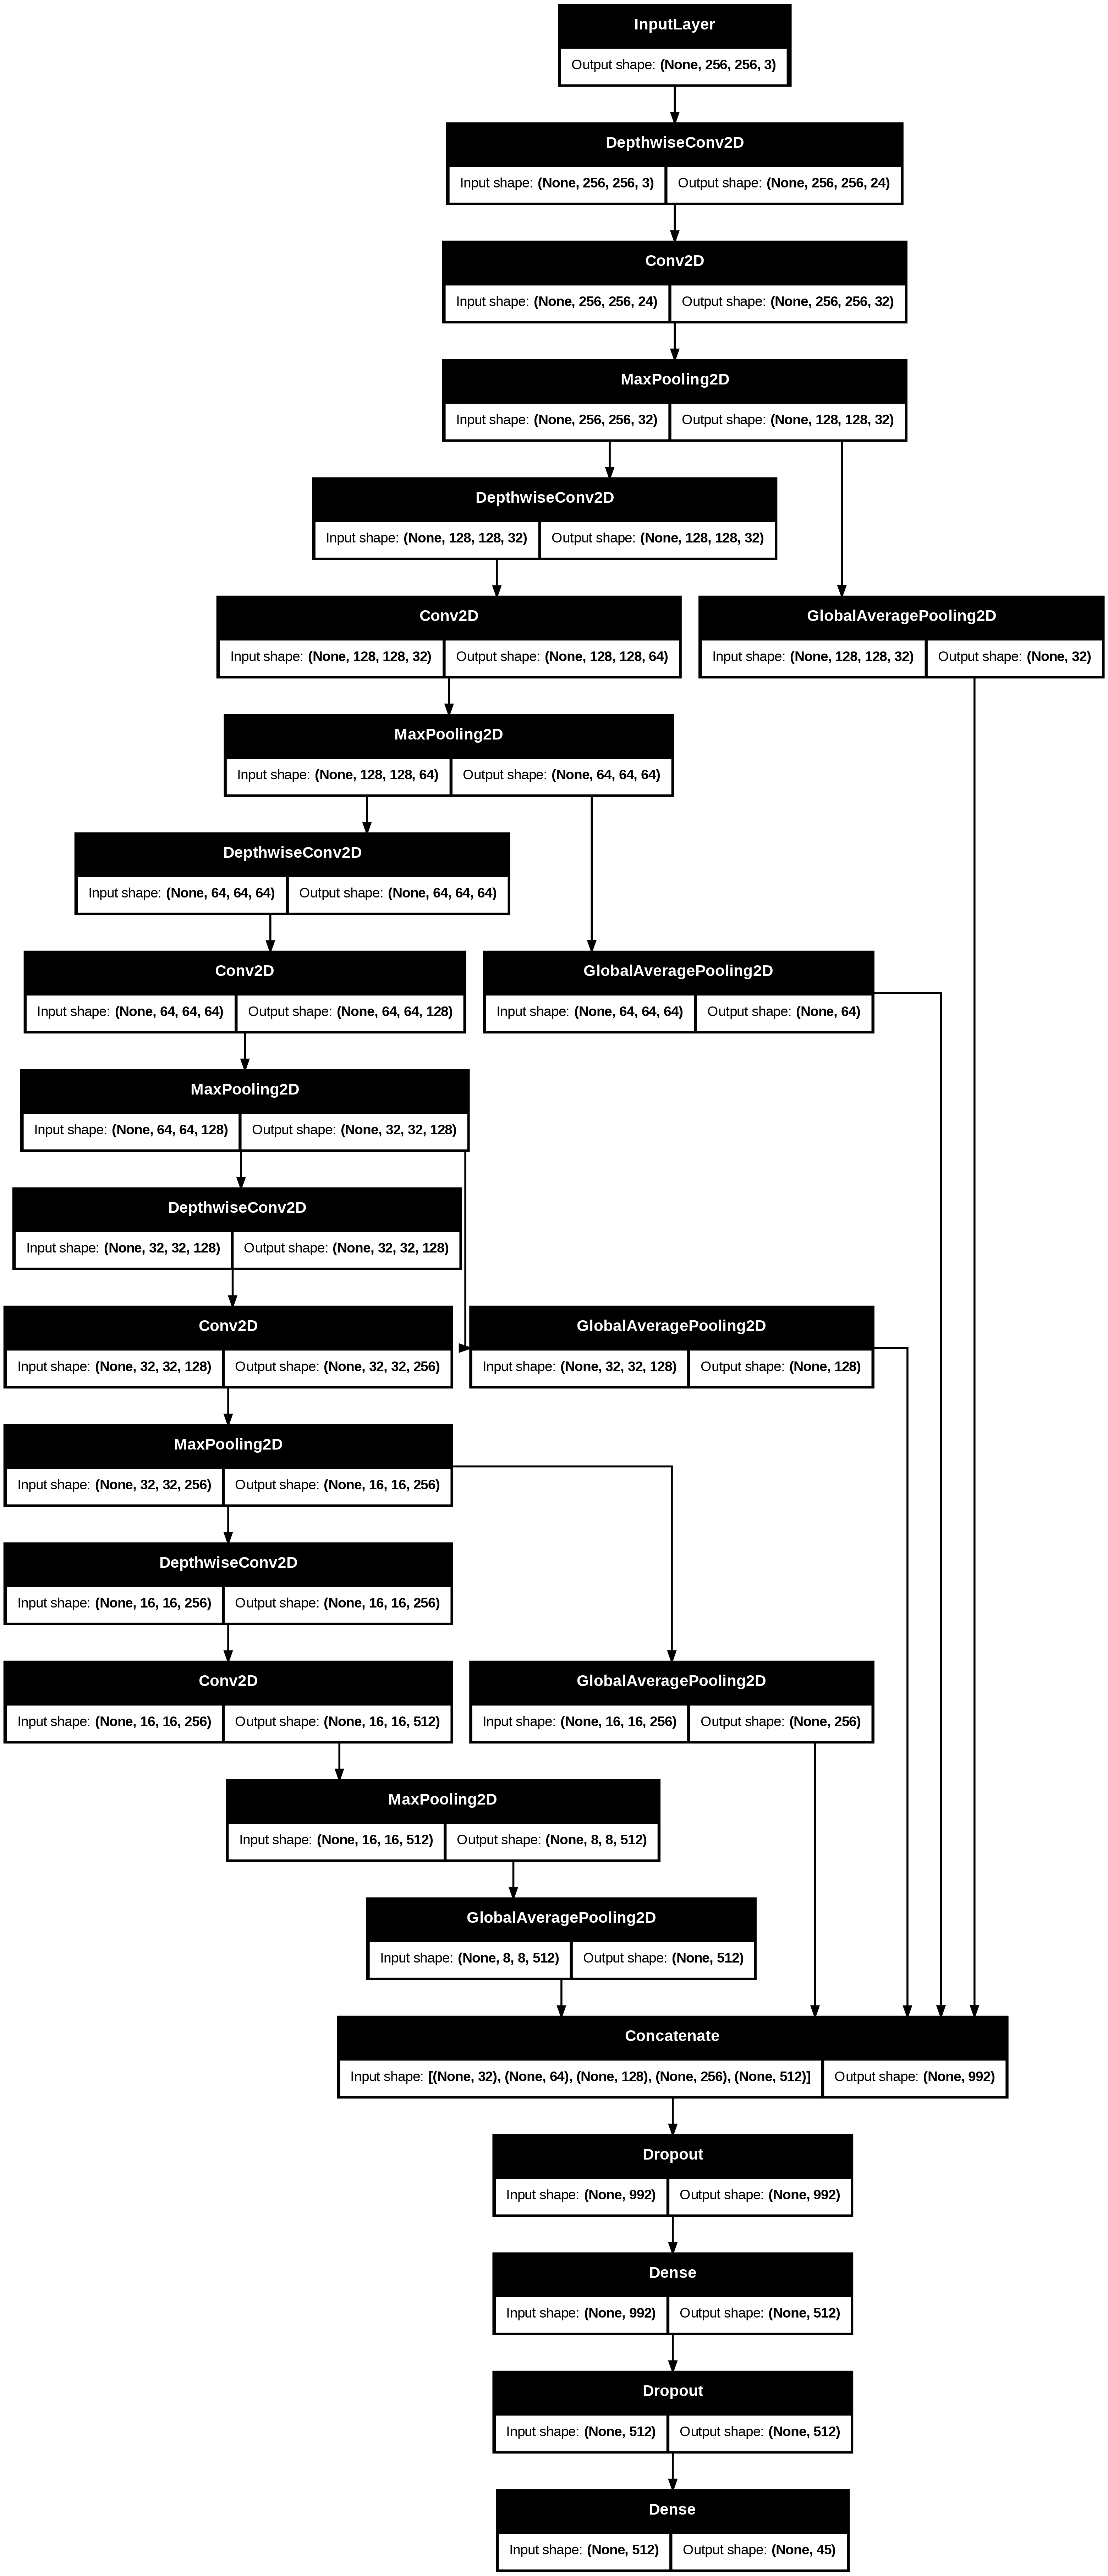

In [74]:
plot_model(model, show_shapes = True, dpi = 200)

In [ ]:
history = model.fit(
    train_data,
    epochs = 10,
    validation_data = valid_data,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1508s 1s/step - accuracy: 0.1672 - loss: 3.0706 - val_accuracy: 0.5588 - val_loss: 1.4790
Epoch 2/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1410s 1s/step - accuracy: 0.5706 - loss: 1.4063 - val_accuracy: 0.7468 - val_loss: 0.8322
Epoch 3/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1456s 1s/step - accuracy: 0.7350 - loss: 0.8546 - val_accuracy: 0.8524 - val_loss: 0.5003
Epoch 4/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1391s 1s/step - accuracy: 0.8190 - loss: 0.5868 - val_accuracy: 0.8657 - val_loss: 0.4485
Epoch 5/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1457s 1s/step - accuracy: 0.8604 - loss: 0.4537 - val_accuracy: 0.9132 - val_loss: 0.2905
Epoch 6/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1424s 1s/step - accuracy: 0.8852 - loss: 0.3713 - val_accuracy: 0.9001 - val_loss: 0.3165
Epoch 7/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1450s 1s/step - accuracy: 0.8991 - loss: 0.3230 - val_accuracy: 0.9371 - val_loss: 0.2112
Epoch 8/10
 399/1105 ━━━━━━━━━━━━━━━━━━━━ 12:45 1s/step - accuracy: 0.9100 - loss: 0.28